  VendorName ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0    adviser     32/60   125   256   6000   256     16    128  198  199
1     amdahl    470v/7    29  8000  32000    32      8     32  269  253
2     amdahl   470v/7a    29  8000  32000    32      8     32  220  253
3     amdahl   470v/7b    29  8000  32000    32      8     32  172  253
4     amdahl   470v/7c    29  8000  16000    32      8     16  132  132
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 no

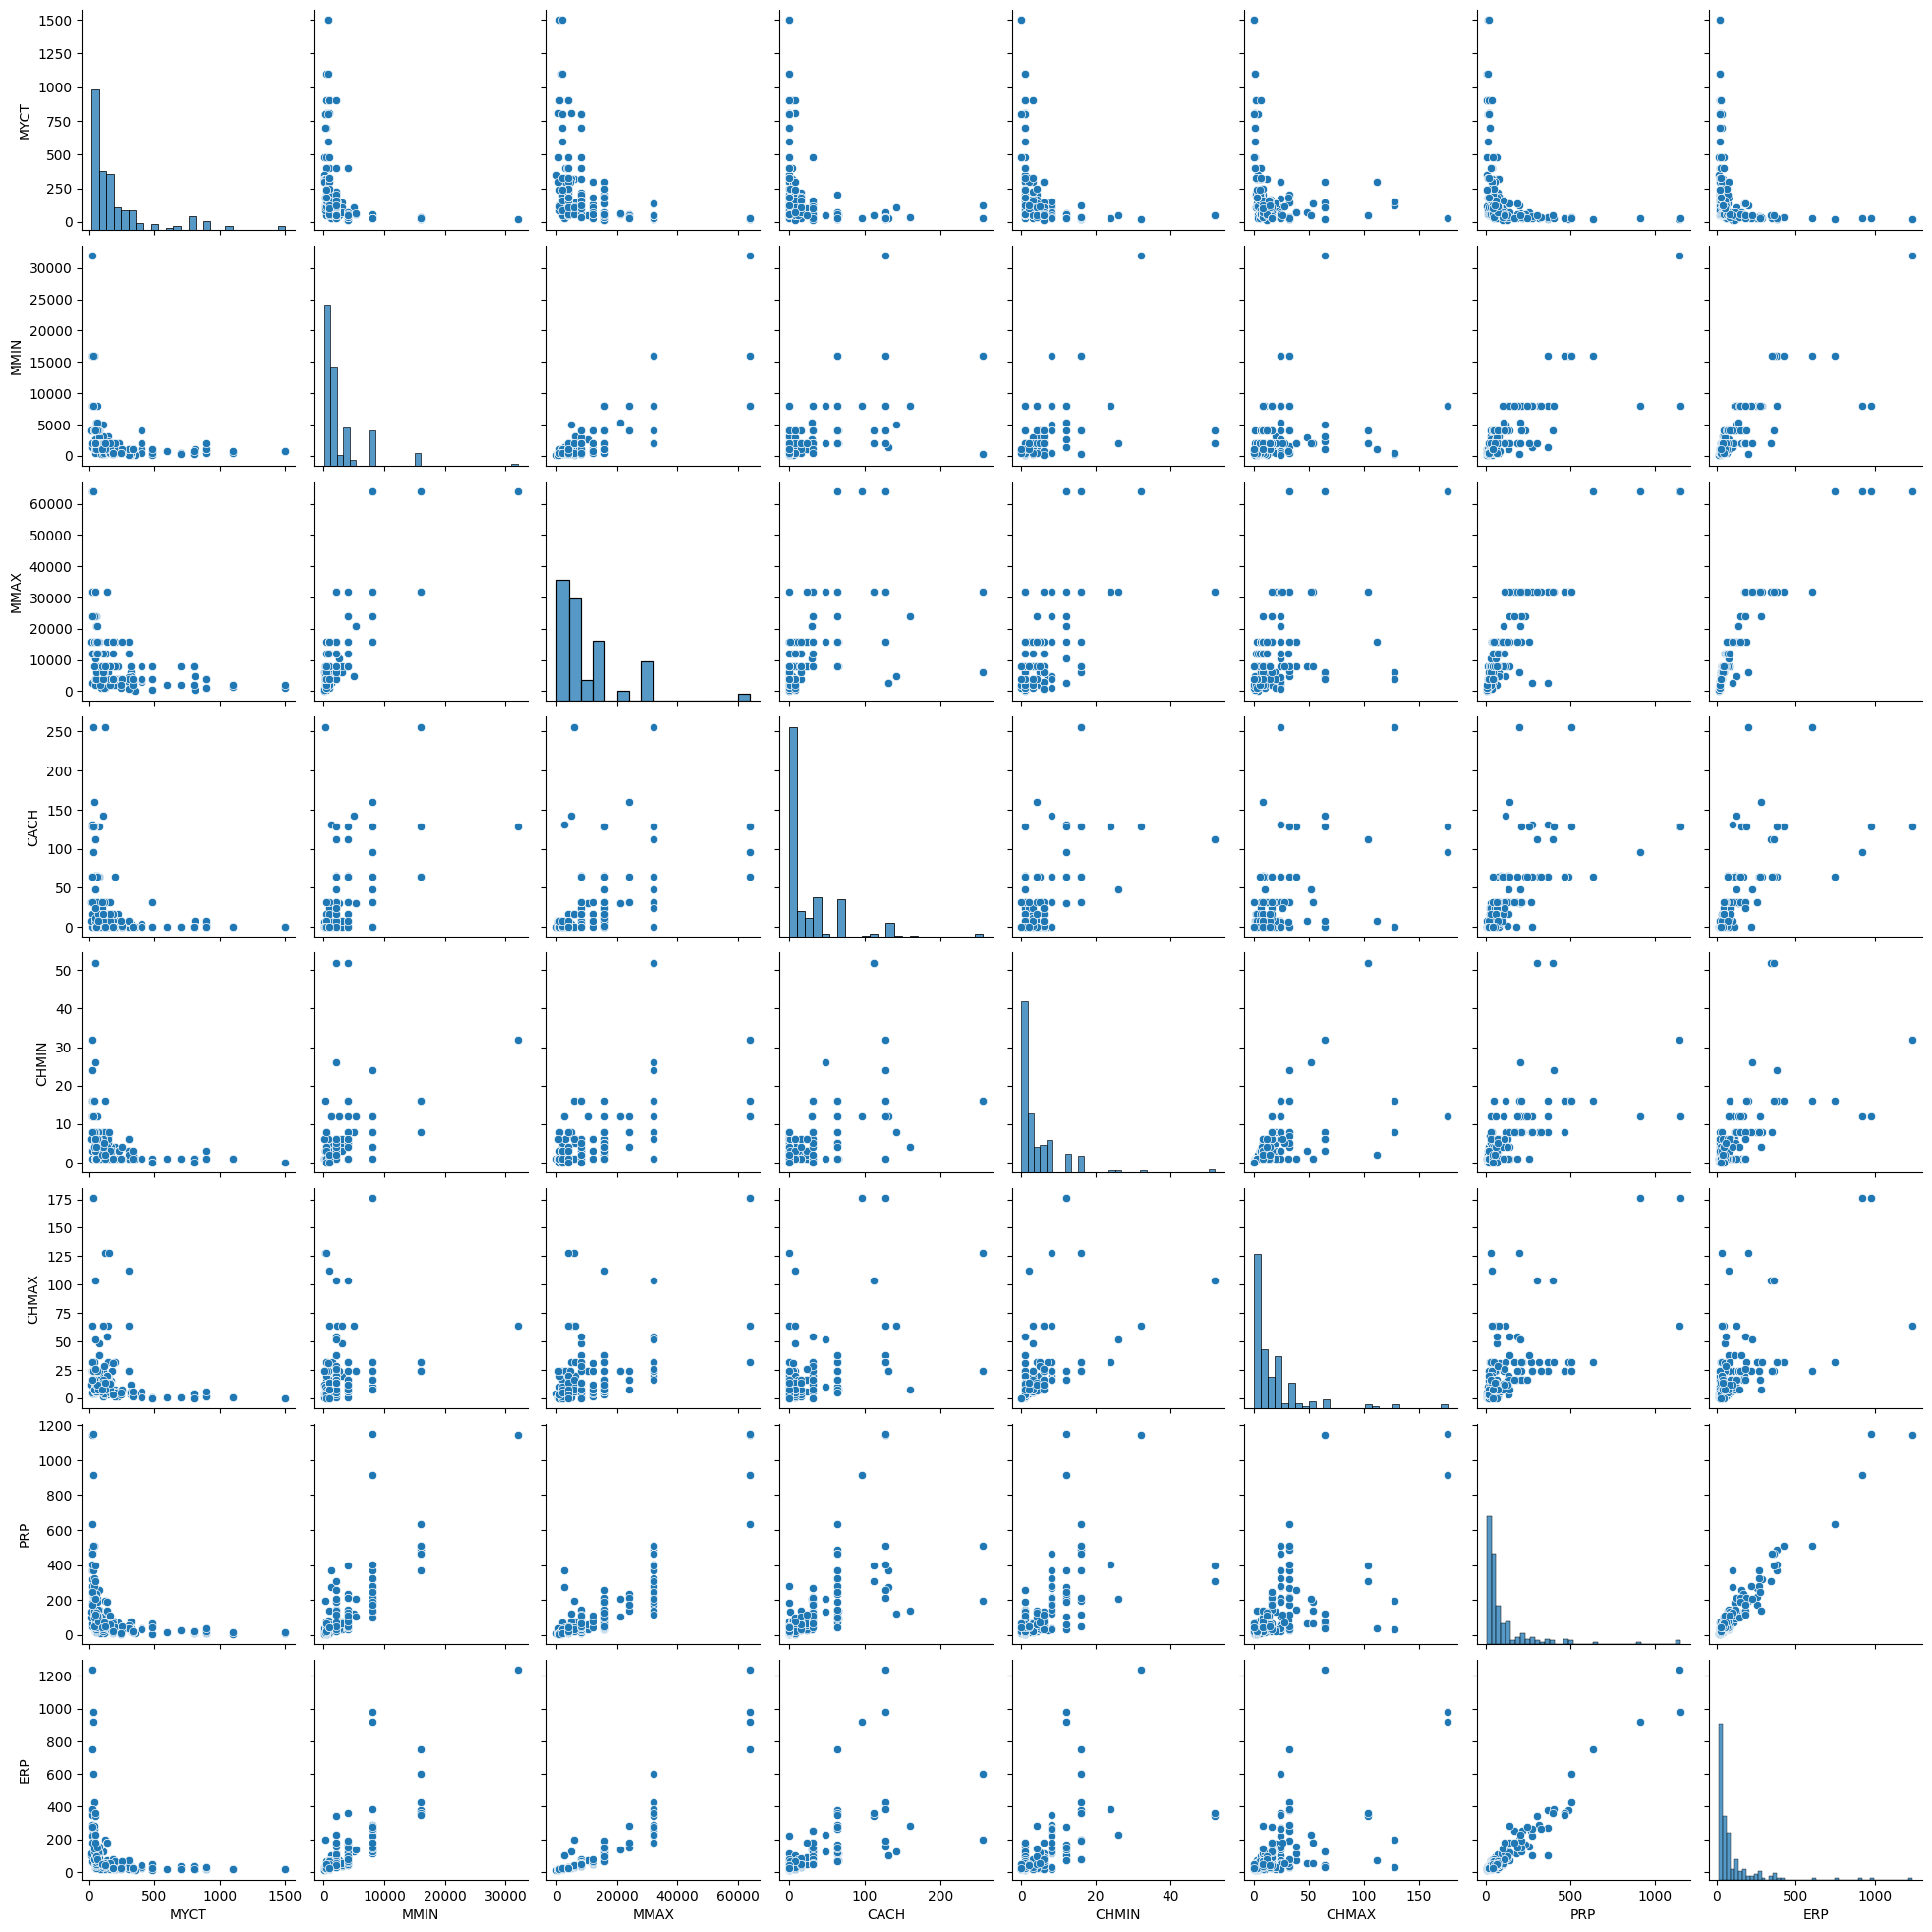

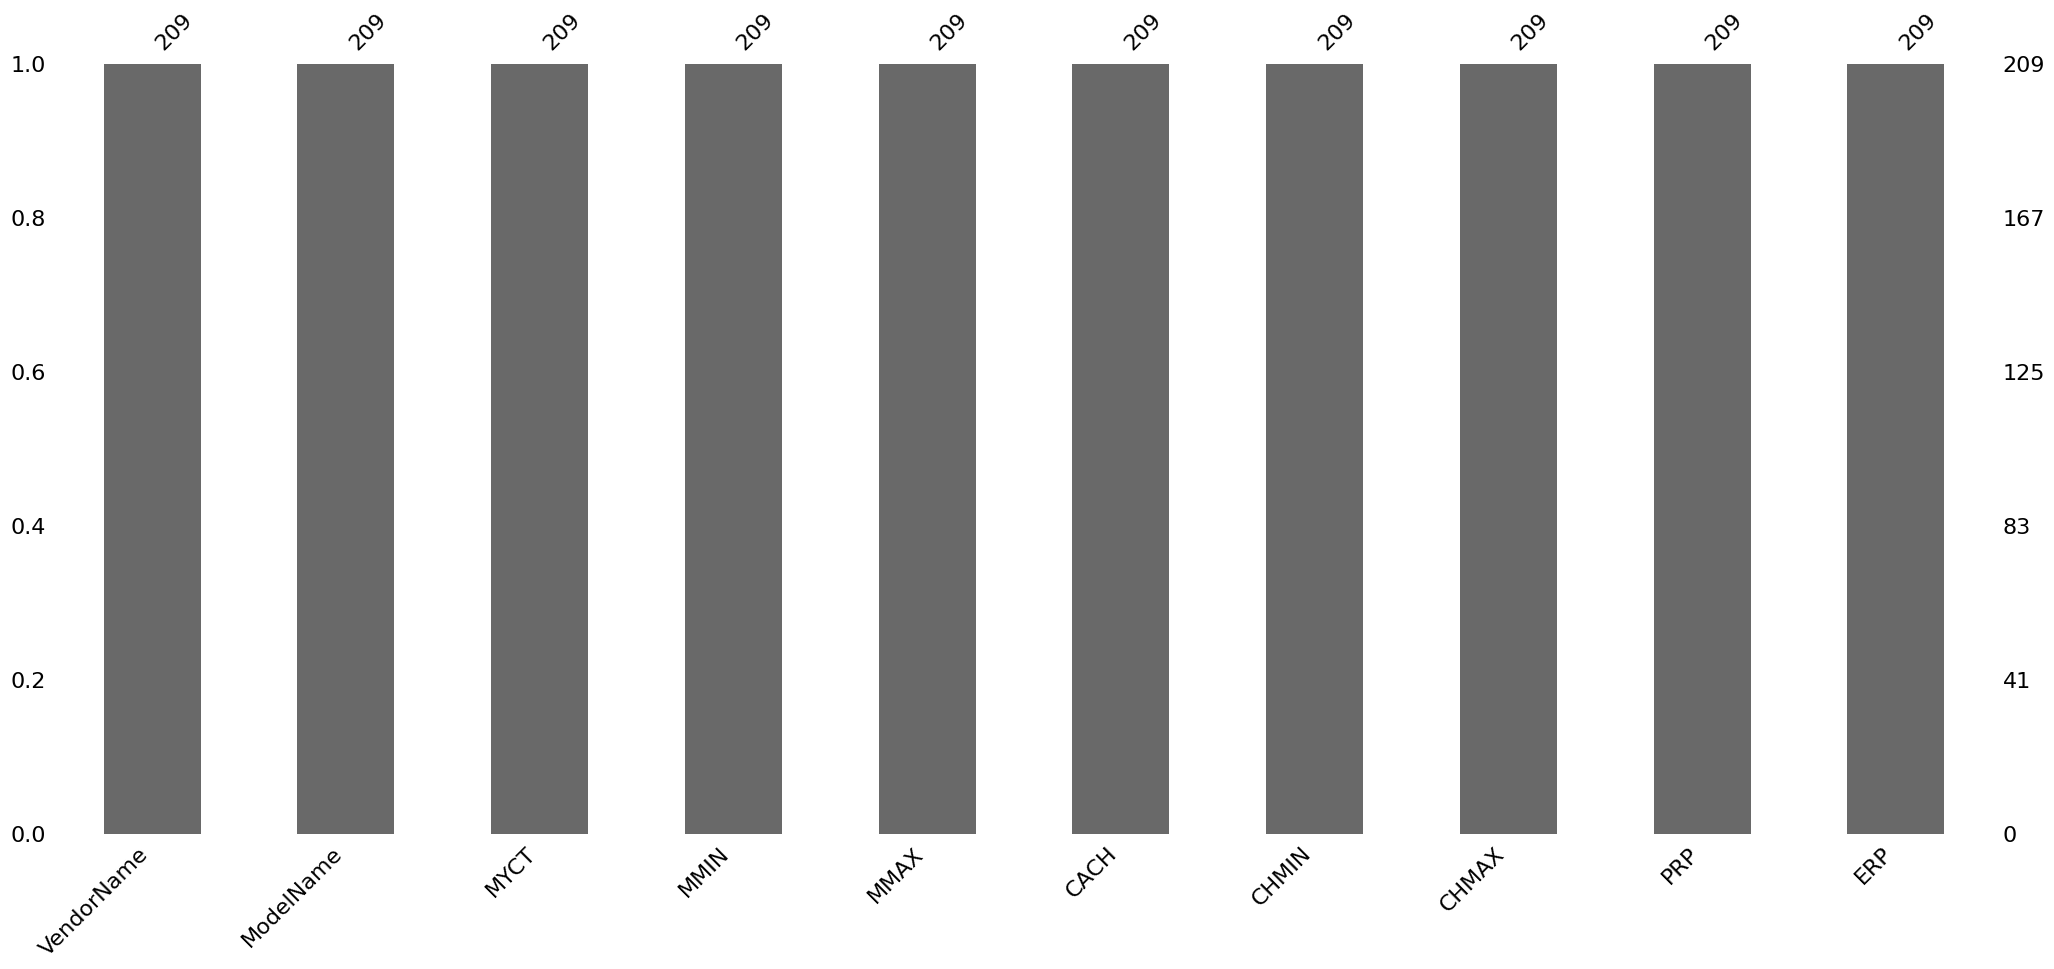

Selected Features: ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
Best Estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MYCT', 'MMIN', 'MMAX',
                                                   'CACH', 'CHMIN',
                                                   'CHMAX'])])),
                ('ensemble',
                 VotingRegressor(estimators=[('lr', LinearRegression()),
                                             ('sgd',
                                              SGDRegressor(alpha=0.01,
                                                           random_state=32)),
                                             ('ridge',
                                              Ridge(alpha=20, random_state=32)),
           

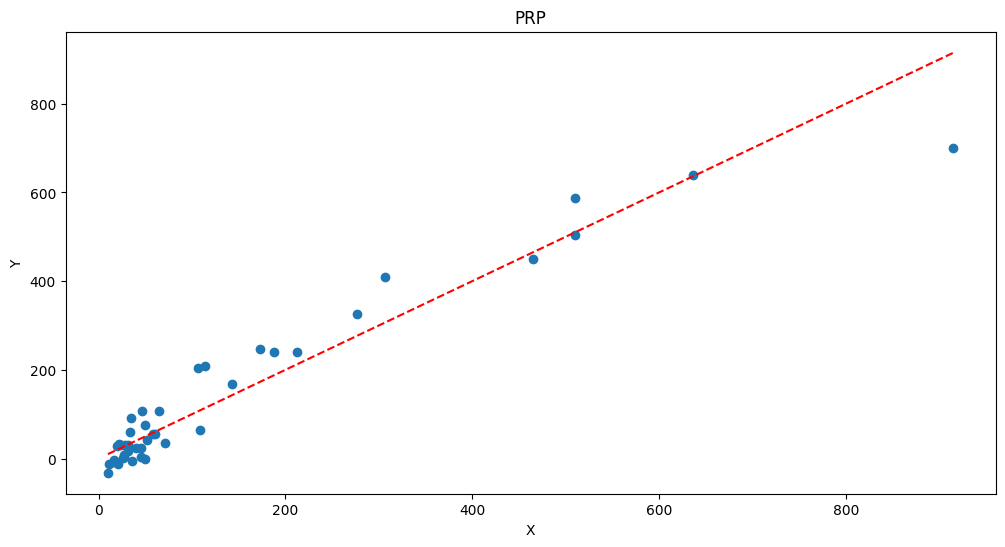

               Model              Data          MSE        MAE       R^2
0  Linear Regression             Train  3345.025454  34.207853  0.816745
1  Linear Regression              Test  4654.851831  45.054513  0.911100
2  Linear Regression  Cross Validation  6622.144368  39.047665  0.624502
3     Best_estimator             Train  1951.272111  25.775327  0.893101
4     Best_estimator              Test  3953.595564  38.970149  0.924493
5     Best_estimator  Cross Validation  5692.435513  33.016503  0.723353


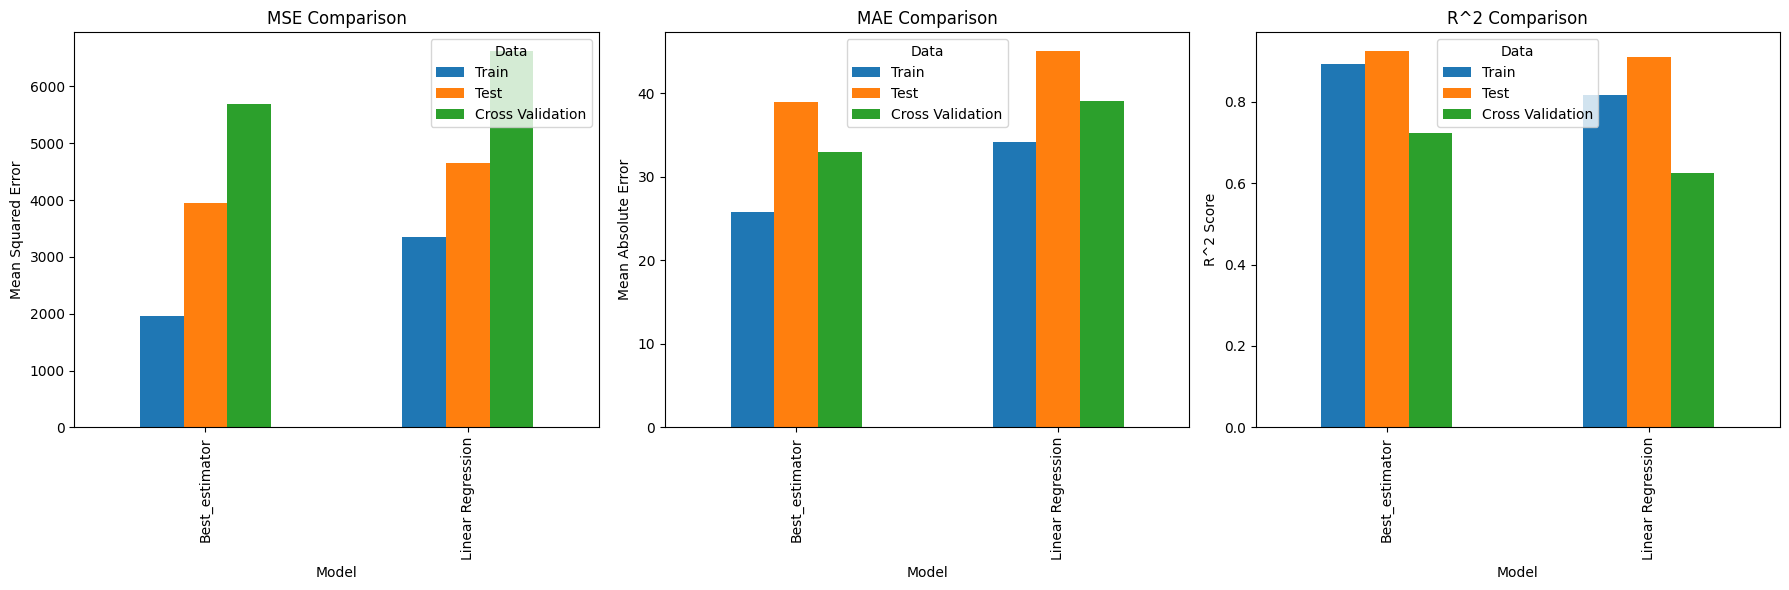

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msn
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor

# 데이터 로드
df = pd.read_csv("machine.data_update.csv")

# 데이터 탐색 및 시각화
print(df.head())
print(df.info())
print(df.describe())
sns.pairplot(df)
plt.show()
msn.bar(df)
plt.show()

# 결측치 제거
df.dropna(inplace=True)

# 범주형 데이터 더미화
dum = pd.get_dummies(df.VendorName, prefix='v', dtype=float)
df = pd.concat([df.drop('VendorName', axis=1), dum], axis=1)

dum = pd.get_dummies(df.ModelName, prefix='m', dtype=float)
df = pd.concat([df.drop('ModelName', axis=1), dum], axis=1)

df.head()

#피처 선택
df_features = ['MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX']  
plt.show()

print(f"Selected Features: {df_features}")

# 데이터 분리
X = df[df_features] 
y = df['PRP']        

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
# 21 - 911
# 30 - 908
# 31 - 904
# 33 - 92499
# 36 - 912
# 49 - 914
# 73 - 92317
# 87 - 9219
# 90 - 91432*

# 전처리
num_tf = Pipeline(steps=[('scaler',StandardScaler()),])

preprocessor = ColumnTransformer(transformers = [('num',num_tf,df_features),])

models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor(random_state=32)),
    ('ridge', Ridge(random_state=32)),
    ('gbr', GradientBoostingRegressor(random_state=32))
]

#앙상블
ensemble = VotingRegressor(estimators=models)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])

#하이퍼파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha': [0.001, 0.01],
    'ensemble__sgd__max_iter': [1000, 2000],
    'ensemble__ridge__alpha': [10, 20],
    'ensemble__gbr__n_estimators': [100, 200], 
    'ensemble__gbr__learning_rate': [0.01, 0.1]
}



# 데이터 학습
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 교차 검증
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5,scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best Estimator:", grid_search.best_estimator_)
print("Best Parameters:", grid_search.best_params_)

y_pred = model.predict(X_test_scaled)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse} MAE: {mae} R^2: {r2}")

# 실제 값과 예측 값 시각화
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PRP')
plt.show()


# 결과를 데이터프레임으로 저장
pf_data = {
    'Model': ['Linear Regression', 'Linear Regression', 'Linear Regression'],
    'Data': ['Train', 'Test', 'Cross Validation'],
    'MSE': [mean_squared_error(y_train, model.predict(X_train_scaled)), mse, cv_mse],
    'MAE': [mean_absolute_error(y_train, model.predict(X_train_scaled)), mae, cv_mae],
    'R^2': [r2_score(y_train, model.predict(X_train_scaled)), r2, cv_r2]
}

rl_df = pd.DataFrame(pf_data)

rl_df.to_csv('pipeline_df_data.csv', index=False)

linear_rl = pd.read_csv('linear_cpu_data.csv')
pipeline_rl = pd.read_csv('pipeline_cpu_data.csv')

df_rl = pd.concat([linear_rl, pipeline_rl], ignore_index=True)

df_rl['Data'] = pd.Categorical(df_rl['Data'], categories=['Train', 'Test', 'Cross Validation'], ordered=True)

print(df_rl)

mse_dt = df_rl.pivot(index='Model', columns='Data', values='MSE')
mae_dt = df_rl.pivot(index='Model', columns='Data', values='MAE')
r2_dt = df_rl.pivot(index='Model', columns='Data', values='R^2')

# 그래프 시각화
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# MSE 
mse_dt.plot(kind='bar', ax=axes[0])
axes[0].set_title('MSE Comparison')
axes[0].set_ylabel('Mean Squared Error')

# MAE 
mae_dt.plot(kind='bar', ax=axes[1])
axes[1].set_title('MAE Comparison')
axes[1].set_ylabel('Mean Absolute Error')

# R^2 
r2_dt.plot(kind='bar', ax=axes[2])
axes[2].set_title('R^2 Comparison')
axes[2].set_ylabel('R^2 Score')


plt.tight_layout()
plt.show()
